# Backtesting trading strategies on historical BTC/USDT data

## Getting the data

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
csv_path = 'data\BTCUSDT-1h-from-2017-08-to-2021-08.csv'

df = pd.read_csv(csv_path)

In [3]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_names = [name for i, name in enumerate(df.columns)]

num_features = df.shape[1]
column_names

['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume']

## Optimal Theoretical Strategy

By seeing the openning price of the next hour, you decide to buy or sell everything now.

In [4]:
#put a certain amount of USDT forward to buy BTC
def buy(acc_usdt, acc_btc, buy_price, buy_amount):
    if(acc_usdt >= buy_amount):
        acc_usdt -= buy_amount
        acc_btc += buy_amount/buy_price
    return acc_usdt, acc_btc

In [5]:
#put a certain amount of BTC forward to buy USDT (aka sell)
def sell(acc_usdt, acc_btc, sell_price, sell_amount):
    if(acc_btc >= sell_amount):
        acc_usdt += sell_amount*sell_price
        acc_btc -= sell_amount
    return acc_usdt, acc_btc

In [6]:
acc_usdt = 1
acc_btc = 0

acc_usdt, acc_btc = buy(acc_usdt, acc_btc, 10000, 1)
print("usdt = " + str(acc_usdt))
print("btc  = " + str(acc_btc))

acc_usdt, acc_btc = sell(acc_usdt, acc_btc, 11000, acc_btc)
print("usdt = " + str(acc_usdt))
print("btc  = " + str(acc_btc))

usdt = 0
btc  = 0.0001
usdt = 1.1
btc  = 0.0


usdt = nan


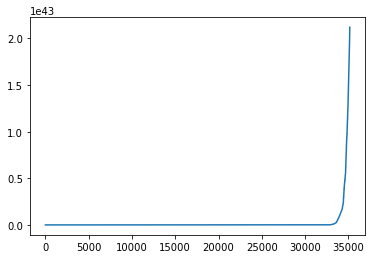

In [7]:
acc_usdt = 1
acc_btc = 0

prev_price = df['Open'][df.index[0]] #USDT
acc_hist = [1]

for i in range(1, len(df)):
    curr_price = df['Open'][df.index[i]] #USDT
    if(curr_price < prev_price):
        acc_usdt, acc_btc = sell(acc_usdt, acc_btc, prev_price, acc_btc)
    if(curr_price > prev_price):
        acc_usdt, acc_btc = buy(acc_usdt, acc_btc, prev_price, acc_usdt)
    acc_usdt_tmp, acc_btc_tmp = sell(acc_usdt, acc_btc, prev_price, acc_btc)
    acc_hist.append(acc_usdt_tmp)
    prev_price = curr_price

acc_usdt, acc_btc = sell(acc_usdt, acc_btc, prev_price, acc_btc)
print("usdt = " + str(acc_usdt))

plt.plot(acc_hist)
#print(acc_hist, sep = "\n")

## 1st strategy : Always Holding

In [8]:
buy_amount = 1 #USDT
buy_price = df['Open'][df.index[0]] #USDT

current_price = df['Open'][df.index[-1]] #USDT

current_holding = current_price / (buy_amount * buy_price)

print("bought at   : " + str(buy_price))
print("price is    : " + str(current_price))
print("so you have : " + str(current_holding))

bought at   : 4261.48
price is    : nan
so you have : nan


### 1.2 : Add 1USDT every hour

In [9]:
acc_usdt = 1
acc_btc = 0

prev_price = df['Open'][df.index[0]] #USDT
acc_hist = [1]

for i in range(0, len(df)-1):
    curr_price = df['Open'][df.index[i]] #USDT
    acc_usdt, acc_btc = buy(1, acc_btc, prev_price, 1)
    acc_usdt_tmp, acc_btc_tmp = sell(acc_usdt, acc_btc, prev_price, acc_btc)
    acc_hist.append(acc_usdt_tmp)
    prev_price = curr_price

acc_usdt, acc_btc = sell(0, acc_btc, prev_price, acc_btc)
print("you invested : " + str(len(df)))
print("you have now : " + str(acc_usdt))

you invested : 35154
you have now : 207400.853755837


## 2nd strategy : KDJ Oscillator

In [10]:
def low(df, curr, p):
    l = df['Low'][curr - p]
    for i in range(curr - p + 1, curr + 1):
        c = df['Low'][i]
        if l > c :
            l = c
    return l

#low(df, df.index[-1], 9)

In [11]:
def high(df, curr, p):
    h = df['High'][curr - p]
    for i in range(curr - p + 1, curr + 1):
        c = df['High'][i]
        if h < c :
            h = c
    return h

#high(df, df.index[-1], 9)

In [12]:
def k(df, curr, p):
    return (df['Close'][curr] - low(df, curr, p))/(high(df, curr, p) - low(df, curr, p))

#k(df, df.index[-1], 9)

In [13]:
def d(df, curr, q):
    k_list = []
    for i in range(q):
        k_list.append(k(df, curr - q + i, q))
    return sum(k_list) / len(k_list)
#d(df, df.index[-1], 3)

In [14]:
#NOT WORKING, NO IDEA WHAT I'M DOING BECAUSE TUTO IS FUCKED
def j(df, curr, p, q):
    return k(df, curr, p)*p + d(df, curr, p)*q
#j(df, df.index[-1], 9, 3)

In [15]:
acc_usdt = 1
acc_btc = 0

prev_price = df['Open'][df.index[0]] #USDT
acc_hist = [1]

for i in range(10, len(df)-1):
    curr_price = df['Open'][df.index[i]] #USDT
    k_curr = k(df, df.index[i], 9)
    d_curr = d(df, df.index[i], 3)
    if(k_curr < d_curr):
        acc_usdt, acc_btc = sell(acc_usdt, acc_btc, prev_price, acc_btc)
    if(k_curr > d_curr):
        acc_usdt, acc_btc = buy(acc_usdt, acc_btc, prev_price, acc_usdt)
    acc_usdt_tmp, acc_btc_tmp = sell(acc_usdt, acc_btc, prev_price, acc_btc)
    acc_hist.append(acc_usdt_tmp)
    prev_price = curr_price

acc_usdt, acc_btc = sell(acc_usdt, acc_btc, prev_price, acc_btc)
print("usdt = " + str(acc_usdt))

usdt = 286823871633.5608


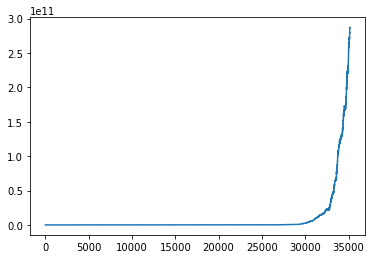

In [16]:
plt.plot(acc_hist)

## Taking fees into account

Binance takes at most 0.1% trading fee

In [17]:
#put a certain amount of USDT forward to buy BTC
#Now with TAXES YEAH
def buy_t(acc_usdt, acc_btc, buy_price, buy_amount):
    if(acc_usdt >= buy_amount):
        acc_usdt -= buy_amount
        acc_btc += (buy_amount - buy_amount*0.001)/buy_price
    return acc_usdt, acc_btc

#put a certain amount of BTC forward to buy USDT (aka sell)
#Now with TAXES YEAH
def sell_t(acc_usdt, acc_btc, sell_price, sell_amount):
    if(acc_btc >= sell_amount):
        acc_usdt += (sell_amount - sell_amount*0.001)*sell_price
        acc_btc -= sell_amount
    return acc_usdt, acc_btc

In [18]:
acc_usdt = 1
acc_btc = 0

prev_price = df['Open'][df.index[0]] #USDT
acc_hist = [1]

for i in range(10, len(df)-1):
    curr_price = df['Open'][df.index[i]] #USDT
    k_curr = k(df, df.index[i], 9)
    d_curr = d(df, df.index[i], 3)
    if(k_curr < d_curr):
        acc_usdt, acc_btc = sell_t(acc_usdt, acc_btc, prev_price, acc_btc)
    if(k_curr > d_curr):
        acc_usdt, acc_btc = buy_t(acc_usdt, acc_btc, prev_price, acc_usdt)
    
    acc_usdt_tmp, acc_btc_tmp = sell_t(acc_usdt, acc_btc, prev_price, acc_btc)
    acc_hist.append(acc_usdt_tmp)
    prev_price = curr_price

acc_usdt, acc_btc = sell(acc_usdt, acc_btc, prev_price, acc_btc)
print("usdt = " + str(acc_usdt))

usdt = 749158.1515070039


## Comparing different time steps

In [19]:
def kdj_fee(df):
    acc_usdt = 1
    acc_btc = 0

    prev_price = df['Open'][df.index[0]] #USDT
    acc_hist = [1]

    for i in range(10, len(df)-1):
        curr_price = df['Open'][df.index[i]] #USDT
        k_curr = k(df, df.index[i], 9)
        d_curr = d(df, df.index[i], 3)
        if(k_curr < d_curr):
            acc_usdt, acc_btc = sell_t(acc_usdt, acc_btc, prev_price, acc_btc)
        if(k_curr > d_curr):
            acc_usdt, acc_btc = buy_t(acc_usdt, acc_btc, prev_price, acc_usdt)

        acc_usdt_tmp, acc_btc_tmp = sell_t(acc_usdt, acc_btc, prev_price, acc_btc)
        acc_hist.append(acc_usdt_tmp)
        prev_price = curr_price

    acc_usdt, acc_btc = sell(acc_usdt, acc_btc, prev_price, acc_btc)
    return acc_usdt

In [20]:
paths = ['data\BTCUSDT-30m-from-2017-08-to-2021-08.csv',
         'data\BTCUSDT-1h-from-2017-08-to-2021-08.csv',
         'data\BTCUSDT-2h-from-2017-08-to-2021-08.csv',
         'data\BTCUSDT-2h-1h-from-2017-08-to-2021-08.csv',
         'data\BTCUSDT-4h-from-2017-08-to-2021-08.csv',
         'data\BTCUSDT-6h-from-2017-08-to-2021-08.csv',
         'data\BTCUSDT-1d-from-2017-08-to-2021-08.csv']

cmp = []

for i, e in enumerate(paths):
    csv_path = paths[i]
    df = pd.read_csv(csv_path)

    cmp.append(kdj_fee(df))
    

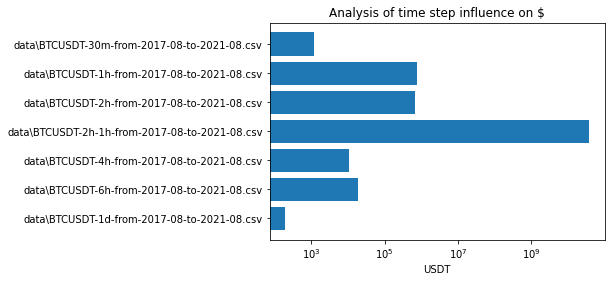

In [21]:
fig, ax = plt.subplots()

y_pos = np.arange(len(paths))

ax.barh(y_pos, cmp, align='center', log=True)
ax.set_yticks(y_pos, labels=paths)
ax.invert_yaxis()
ax.set_xlabel('USDT')
ax.set_title('Analysis of time step influence on $')

plt.show()

Ok, apparently if i take 1/2 of the data of 1h, i get a massive boost, so let's try that better.
So, given 1h data, we act every 2h instead of every 1h.

In [22]:
def kdj_2H(df):
    acc_usdt = 1
    acc_btc = 0

    prev_price = df['Open'][df.index[0]] #USDT
    acc_hist = [1]

    for i in range(30, len(df)-1, 2):
        curr_price = df['Open'][df.index[i]] #USDT
        k_curr = k(df, df.index[i], 9)
        d_curr = d(df, df.index[i], 3)
        if(k_curr < d_curr):
            acc_usdt, acc_btc = sell_t(acc_usdt, acc_btc, prev_price, acc_btc)
        if(k_curr > d_curr):
            acc_usdt, acc_btc = buy_t(acc_usdt, acc_btc, prev_price, acc_usdt)

        acc_usdt_tmp, acc_btc_tmp = sell_t(acc_usdt, acc_btc, prev_price, acc_btc)
        acc_hist.append(acc_usdt_tmp)
        prev_price = curr_price

    acc_usdt, acc_btc = sell(acc_usdt, acc_btc, prev_price, acc_btc)
    return acc_usdt

In [23]:
csv_path = 'data\BTCUSDT-1h-from-2017-08-to-2021-08.csv'
df = pd.read_csv(csv_path)

print(kdj_2H(df))

10.887671062720928


Ah... maybe not then.

In [54]:
def kdj_2H_better(df):
    acc_usdt = 1
    acc_btc = 0

    prev_price = df['Open'][df.index[0]] #USDT
    acc_hist = [acc_usdt]

    for i in range(30, len(df)-1, 2):
        curr_price = df['Open'][df.index[i]] #USDT
        k_curr = k(df, df.index[i], 30)
        d_curr = d(df, df.index[i], 10)
        if(k_curr < d_curr):
            acc_usdt, acc_btc = sell_t(acc_usdt, acc_btc, prev_price, acc_btc)
        if(k_curr > d_curr):
            acc_usdt, acc_btc = buy_t(acc_usdt, acc_btc, prev_price, acc_usdt)

        acc_usdt_tmp, acc_btc_tmp = sell_t(acc_usdt, acc_btc, prev_price, acc_btc)
        acc_hist.append(acc_usdt_tmp)
        prev_price = curr_price

    acc_usdt, acc_btc = sell(acc_usdt, acc_btc, prev_price, acc_btc)
    return acc_usdt, acc_hist

In [55]:
csv_path = 'data\BTCUSDT-1h-from-2017-08-to-2021-08.csv'
df = pd.read_csv(csv_path)

acc_usdt, acc_hist = kdj_2H_better(df)

In [56]:
print(acc_usdt)

index = []
for i,e in enumerate(acc_hist):
    index.append([i, acc_hist[i]])
print(*index, sep = '\n')

378957105145.3662


## New plan: variation of the window length and the time step

In [88]:
def kdj_var(df, w):
    acc_usdt = 1
    acc_btc = 0

    prev_price = df['Open'][df.index[0]] #USDT
    acc_hist = [acc_usdt]

    for i in range(3*w, len(df)-1):
        curr_price = df['Open'][df.index[i]] #USDT
        k_curr = k(df, df.index[i], 3*w)
        d_curr = d(df, df.index[i], w)
        if(k_curr < d_curr):
            acc_usdt, acc_btc = sell_t(acc_usdt, acc_btc, prev_price, acc_btc)
        if(k_curr > d_curr):
            acc_usdt, acc_btc = buy_t(acc_usdt, acc_btc, prev_price, acc_usdt)

        acc_usdt_tmp, acc_btc_tmp = sell_t(acc_usdt, acc_btc, prev_price, acc_btc)
        acc_hist.append(acc_usdt_tmp)
        prev_price = curr_price

    acc_usdt, acc_btc = sell(acc_usdt, acc_btc, prev_price, acc_btc)
    return acc_usdt

In [89]:
paths = ['data\BTCUSDT-30m-from-2017-08-to-2021-08.csv',
         'data\BTCUSDT-1h-from-2017-08-to-2021-08.csv',
         'data\BTCUSDT-2h-from-2017-08-to-2021-08.csv',
         'data\BTCUSDT-2h-1h-from-2017-08-to-2021-08.csv',
         'data\BTCUSDT-4h-from-2017-08-to-2021-08.csv',
         'data\BTCUSDT-6h-from-2017-08-to-2021-08.csv',
         'data\BTCUSDT-1d-from-2017-08-to-2021-08.csv']

cmp = np.zeros((7, 12))

for i, e in enumerate(paths):
    print(e)
    for w in range(3, 12):
        print(w)
        csv_path = paths[i]
        df = pd.read_csv(csv_path)

        cmp[i][w] = kdj_var(df, w)

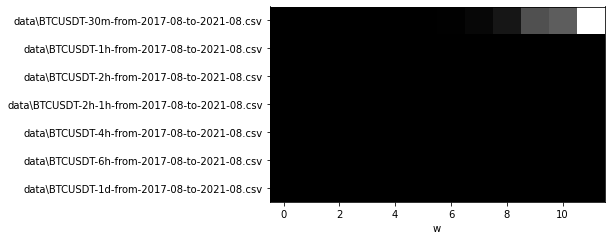

In [90]:
fig, ax = plt.subplots()

ax.set_yticks(y_pos, labels=paths)
ax.set_xlabel('w')
ax.imshow(cmp, cmap='gray')

In [97]:
np.set_printoptions(formatter={'float_kind':'{:.2e}'.format})
print(cmp)

[[0.00e+00 0.00e+00 0.00e+00 1.18e+03 1.55e+09 3.15e+12 1.53e+14 6.00e+14
  1.87e+15 6.80e+15 7.89e+15 2.17e+16]
 [0.00e+00 0.00e+00 0.00e+00 7.49e+05 4.11e+09 1.60e+11 1.60e+12 6.21e+12
  1.67e+13 1.14e+13 1.12e+13 7.20e+12]
 [0.00e+00 0.00e+00 0.00e+00 6.55e+05 9.80e+07 3.91e+08 7.44e+08 1.83e+09
  3.92e+09 5.38e+09 7.05e+09 1.31e+10]
 [0.00e+00 0.00e+00 0.00e+00 3.87e+10 9.42e+11 1.23e+12 1.27e+12 1.86e+12
  1.85e+12 1.52e+12 2.28e+12 1.94e+12]
 [0.00e+00 0.00e+00 0.00e+00 1.09e+04 8.23e+05 1.01e+07 2.64e+07 3.24e+07
  5.37e+07 2.96e+07 3.18e+07 3.18e+07]
 [0.00e+00 0.00e+00 0.00e+00 1.90e+04 3.03e+05 2.67e+06 3.12e+06 3.75e+06
  3.81e+06 4.44e+06 5.14e+06 3.04e+06]
 [0.00e+00 0.00e+00 0.00e+00 1.88e+02 8.92e+02 1.89e+03 2.96e+03 7.58e+03
  7.05e+03 7.29e+03 4.64e+03 3.96e+03]]


Ok, so maybe small time steps large windows then